Author: Emily Wong \
February 16, 2023

# Resources

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/#4

https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

https://neptune.ai/blog/cross-validation-mistakes

# 1. Import libraries, methods, and data

## 1.1. Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data wrangling
import pandas as pd
import numpy as np
from numpy.random import uniform, normal, seed

# Machine learning
import sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split
import scipy
from scipy.stats import randint
import xgboost as xgb
from imblearn.over_sampling import SMOTENC, RandomOverSampler, SMOTE
from imblearn.under_sampling import TomekLinks, NeighbourhoodCleaningRule, EditedNearestNeighbours, RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
import optuna

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns # for kernel density plots

# for nested dictionary
import collections
def makehash():
    return collections.defaultdict(makehash)

# Fairness
import aif360
import fairlearn
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio, false_negative_rate

The __demographic parity difference__ of 0 means that all groups have the same selection rate. For multiple groups, average across all pairwise differences. Ranges between 0 and 1.

The __demographic parity ratio__ of 1 means that all groups have the same selection rate.

The __equalized odds difference__ of 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.

The __equalized odds ratio__ of 1 means that all groups have the same true positive, true negative, false positive, and false negative rates.

## 1.2 Reweighing Method

In [3]:
def calc_weights(df, sens_features_name, outcome_name):
    ''' Calculate sample weights according to calculationg given in 
           F. Kamiran and T. Calders,  "Data Preprocessing Techniques for
           Classification without Discrimination," Knowledge and Information
           Systems, 2012.
    ''' 
    
    # combination of label and groups (outputs a table)
    sens_features = df[sens_features_name]
    outcome = df[outcome_name]
    tab = pd.DataFrame(pd.crosstab(index=sens_features, columns=outcome))

    # reweighing weights
    w = makehash()
    n = len(df)
    for r in tab.index:
        key1 = str(r)
        row_sum = tab.loc[r].sum(axis=0)
        for c in tab.columns:
            key2 = str(c)
            col_sum = tab[c].sum()
            if tab.loc[r,c] == 0:
                n_combo = 1
            else:
                n_combo = tab.loc[r,c]
            val = (row_sum*col_sum)/(n*n_combo)
            w[key1][key2] = val
    
    # Instance weights
    instance_weights = []
    for index, row in df.iterrows():
        race = row[sens_features_name]
        out = row[outcome_name]
        instance_weights.append(w[race][str(out)])

    return instance_weights

In [4]:
def display_performance(X_train, y_train, X_test, y_test, model):
    # Train performance
    y_train_pred = model.predict(X_train)
    print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
    print("Train Balanced Acc:",np.round(sklearn.metrics.balanced_accuracy_score(y_train, y_train_pred),5))
    cm = confusion_matrix(y_train, y_train_pred)
    print("Train Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

    print("")

    # Test performance
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", np.round(test_accuracy,5))
    print("Test Balanced Acc:",np.round(sklearn.metrics.balanced_accuracy_score(y_test, y_pred),5))
    cm = confusion_matrix(y_test, y_pred)
    print("Test Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

In [5]:
def optim_thresh(X_test, y_test, model):
    # Find optimal threshold
    step_factor = 0.05 
    threshold_value = 0.05
    roc_score=0
    predicted_proba = model.predict_proba(X_test) #probability of prediction
    while threshold_value <=0.8: #continue to check best threshold upto probability 0.8
        temp_thresh = threshold_value
        predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') #change the class boundary for prediction
        if roc_score<roc_auc_score(y_test, predicted, multi_class='ovo'): #store the threshold for best classification
            roc_score = roc_auc_score(y_test, predicted)
            thrsh_score = threshold_value
        threshold_value = threshold_value + step_factor
    print('---Optimum Threshold ---',np.round(thrsh_score,5),'--ROC--',np.round(roc_score,5))

    optim_thresh = thrsh_score
    y_pred_optim = (predicted_proba [:,1] >= optim_thresh).astype('int')
    print("Optimal Test Accuracy:",np.round(accuracy_score(y_test, y_pred_optim),5))
    print("Optimal Test Balanced Accuracy:",np.round(balanced_accuracy_score(y_test, y_pred_optim),5))
    print("Optimal Test AUC:",np.round(sklearn.metrics.roc_auc_score(y_test, y_pred_optim, multi_class='ovo'),5))

    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred_optim)
    print("Test Confusion Matrix w/ Optimal Threshold:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);
    
    return thrsh_score
    

## 1.3. Data

In [6]:
all_data = pd.read_excel("Eynav cleaned data.xlsx")

In [7]:
print(all_data.shape)

(19790, 43)


In [8]:
print(all_data.columns)

Index(['DELIVERY_TIME', 'MOM_PAT_ID', 'FINANCIAL_CLASS', 'PRIMARY_PAYOR_NAME',
       'MARITAL_STATUS', 'ZIP', 'MOM_AGE', 'MOM_RACE', 'ETHNIC_GROUP',
       'CHILD_BIRTH_WT', 'LBW', 'CHILD_GESTATION_AGE_NUMBER', 'PTB',
       'DELIVERY_METHOD', 'NOTE_SW', 'NICU_ADMIT', 'MFCU_ADMIT', 'GRAVIDITY',
       'PARITY', 'ABORTIONS', 'PREE', 'GDM', 'GHTN', 'MOM_BMI', 'MOM_LOS',
       'CHILD_LOS', 'HISTORIC_DX_LIST', 'MED_PSYCH', 'MED_CARDIO', 'ANSWER11',
       'PHQ9_VALUE', 'EPDSANSWER10', 'TOTAL_EPDS_VALUE',
       'MENTAL_HEALTH_DX_CUTOFF', 'HIST_ANXIETY', 'HIST_DEPRESS',
       'HIST_BIPOLAR', 'HIST_PMAD', 'EPDS_risk', 'EPDS_risk2', 'PHQ9_risk',
       'PHQ9_risk2', 'PMAD_risk'],
      dtype='object')


This below chuck is only for reporting demographic information in manuscript:

In [9]:
demo = all_data[['MOM_AGE','MOM_RACE','ETHNIC_GROUP','ZIP','MARITAL_STATUS','FINANCIAL_CLASS',
                 'LBW','PTB',
                 'DELIVERY_METHOD','NICU_ADMIT','MFCU_ADMIT',
                 'PREE','GDM','GHTN',
                 'MOM_BMI','MOM_LOS','CHILD_LOS',
                 'HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_PMAD','MENTAL_HEALTH_DX_CUTOFF',
                 'MED_PSYCH','MED_CARDIO','PMAD_risk']]
demo = demo.dropna()            # keep only complete data (for now)
demo = demo.sample(len(demo))   # randomly shuffle rows
demo.shape

print("Min Age:",min(demo['MOM_AGE']))
print("Max Age:",max(demo['MOM_AGE']))
print("Mean Age:",np.mean(demo['MOM_AGE']))
print("SD Age:",np.std(demo['MOM_AGE']))

print("------------RACE/ETHNIC COUNTS------------")
race = demo['MOM_RACE']
ethnic = demo['ETHNIC_GROUP']
print(pd.DataFrame(pd.crosstab(index=race, columns=ethnic)))

Min Age: 14.0
Max Age: 59.0
Mean Age: 34.13058472308009
SD Age: 4.861398430101049
------------RACE/ETHNIC COUNTS------------
ETHNIC_GROUP                                        Hispanic  Non-Hispanic  \
MOM_RACE                                                                     
Asian or Native Hawaiian or Other Pacific Islander        21          2330   
Black or African American                                 53          1346   
Hispanic White                                          1842             0   
Multiracial                                              140           420   
Other                                                   1000          1113   
Unknown                                                   33            40   
White                                                      0         10855   

ETHNIC_GROUP                                        Unknown  
MOM_RACE                                                     
Asian or Native Hawaiian or Other Pacific Island

In [10]:
print(demo.shape)

(19428, 25)


Extract relevant variables for model fitting:

In [11]:
outcome = 'PHQ9_risk2'

data = all_data[['MOM_AGE','MOM_RACE','ETHNIC_GROUP','ZIP','MARITAL_STATUS','FINANCIAL_CLASS',
                 'LBW','PTB',
                 'DELIVERY_METHOD','NICU_ADMIT','MFCU_ADMIT',
                 'PREE','GDM','GHTN',
                 'MOM_BMI','MOM_LOS','CHILD_LOS',
                 'HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_PMAD','MENTAL_HEALTH_DX_CUTOFF',
                 'MED_PSYCH','MED_CARDIO',
                 outcome,'PHQ9_VALUE']]

## 1.3.3. Curate Data

In [12]:
data = data.dropna()            # keep only complete data (for now)
data = data.sample(len(data))   # randomly shuffle rows
data.shape

(11375, 26)

In [13]:
scale_data = data[['MOM_RACE','ETHNIC_GROUP','PHQ9_VALUE','PHQ9_risk2']]

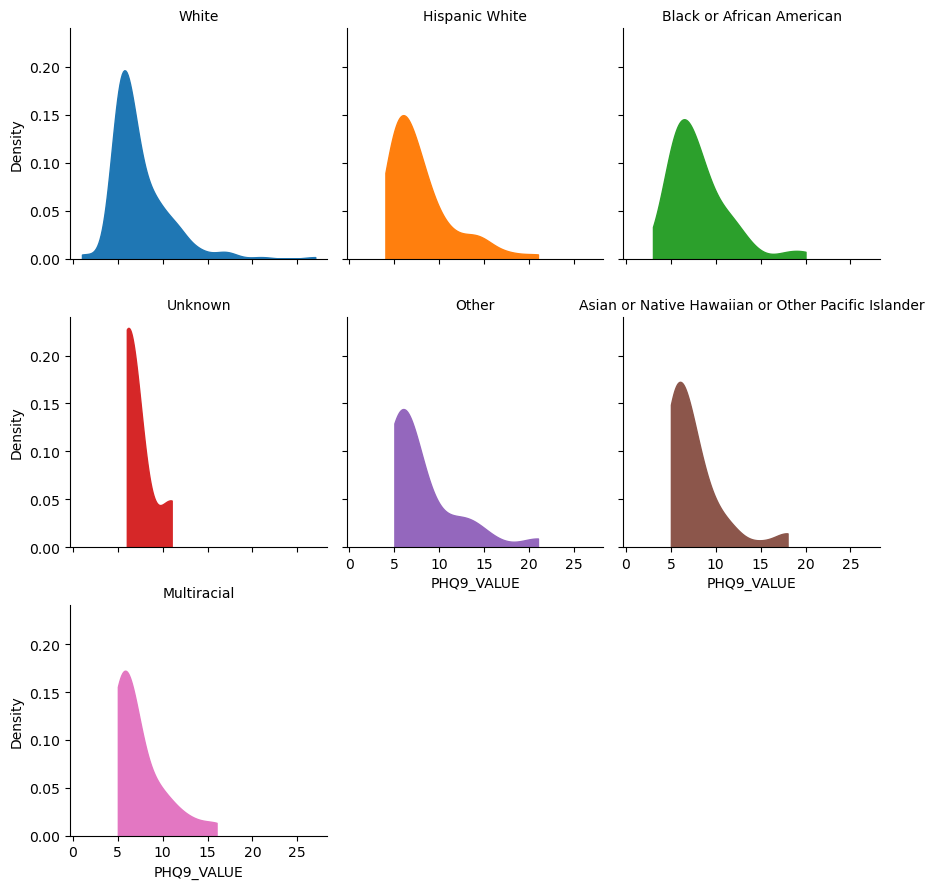

In [14]:
scale_data2 = scale_data[scale_data.PHQ9_risk2==1]

# create a grid 
g = sns.FacetGrid(scale_data2, col='MOM_RACE', hue='MOM_RACE', col_wrap=3)

# draw density plots
g = g.map(sns.kdeplot,"PHQ9_VALUE", cut=0, fill=True, common_norm=False, alpha=1, legend=False)

# control the title of each facet
g = g.set_titles("{col_name}")

# show the graph
#plt.show()

plt.savefig('Figure 1.png',dpi=600)

In [15]:
data = data.drop(['PHQ9_VALUE'], axis=1)

In [16]:
race = data['MOM_RACE']
ethnic = data['ETHNIC_GROUP']
out = data[outcome]

print("------------MEDIAN AGE------------")
print(pd.crosstab(index=race, columns=ethnic, values=data['MOM_AGE'], aggfunc=np.median))
print("Overall median age:",np.median(data[['MOM_AGE']]))

print("------------RACE/ETHNIC COUNTS------------")
print(pd.DataFrame(pd.crosstab(index=race, columns=ethnic)))

print("------------RACE/ETHNIC PMAD------------")
print(pd.crosstab(index=[ethnic,race], columns=out, normalize='index'))

print("Overall PMAD:",np.mean(data[[outcome]]))

------------MEDIAN AGE------------
ETHNIC_GROUP                                        Hispanic  Non-Hispanic  \
MOM_RACE                                                                     
Asian or Native Hawaiian or Other Pacific Islander      33.0          35.0   
Black or African American                               34.0          33.0   
Hispanic White                                          33.0           NaN   
Multiracial                                             34.0          35.0   
Other                                                   32.0          34.0   
Unknown                                                 35.0          32.5   
White                                                    NaN          34.0   

ETHNIC_GROUP                                        Unknown  
MOM_RACE                                                     
Asian or Native Hawaiian or Other Pacific Islander     31.5  
Black or African American                              34.5  
Hispanic White

10875 500


<BarContainer object of 2 artists>

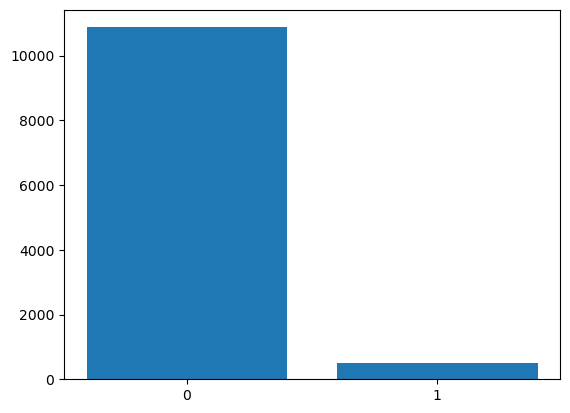

In [17]:
# binary-class
count0, count1 = data[outcome].value_counts()
print(count0, count1)

x = ['0','1']
y = [count0, count1]
plt.bar(x, y)

In [18]:
print("N:",data.shape)

N: (11375, 25)


## 1.3.4. Weight Data

In [19]:
data['w'] = calc_weights(df=data, sens_features_name="MOM_RACE", outcome_name=outcome)

In [20]:
data[['w',outcome,'MOM_RACE']].drop_duplicates()

,w,PHQ9_risk2,MOM_RACE
896,0.999761,0.0,Asian or Native Hawaiian or Other Pacific Isla...
12574,0.992656,0.0,White
19011,1.191758,1.0,White
13707,1.031702,0.0,Multiracial
10187,0.996324,0.0,Other
9877,1.021257,0.0,Black or African American
19599,0.682911,1.0,Hispanic White
2184,1.021814,0.0,Hispanic White
10711,0.688368,1.0,Black or African American
8425,1.064275,0.0,Unknown


## 1.3.5. Get Dummies and Split

In [21]:
# get dummy variables
data = pd.get_dummies(data)

Split data. Can specify whether to use stratify sampling or not.

In [22]:
# split into X and y
X = data.drop([outcome], axis=1)
y = data[[outcome]]

race = data[['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
             'MOM_RACE_Black or African American',
             'MOM_RACE_Multiracial',
             'MOM_RACE_Other',
             'MOM_RACE_Unknown',
             'MOM_RACE_White',
             'MOM_RACE_Hispanic White']]
strat_df = pd.concat([y,race],axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, shuffle=True, stratify=strat_df, random_state=0)
X_test = X_test.drop(['w'], axis=1)

# Sensitive features
race_feature = X_test[['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
                       'MOM_RACE_Black or African American',
                       'MOM_RACE_Multiracial',
                       'MOM_RACE_Other',
                       'MOM_RACE_Unknown',
                       'MOM_RACE_White',
                       'MOM_RACE_Hispanic White']]

In [23]:
# binary-class
count0_train, count1_train = y_train.value_counts()
print(count0_train, count1_train)

count0_test, count1_test = y_test.value_counts()
print(count0_test, count1_test)

9242 426
1633 74


# 2. Handle imbalanced data

## 2.1. Simple Over Sampling Minority (PMAD)

In [24]:
ros = RandomOverSampler(sampling_strategy = "auto",random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
weights_ros = X_train_ros['w']
X_train_ros = X_train_ros.drop(['w'], axis=1)
y_train_ros.value_counts()

PHQ9_risk2
0.0           9242
1.0           9242
Name: count, dtype: int64

## 2.2. Simple Under Sampling Majority (PMAD)

In [25]:
rus = RandomUnderSampler(sampling_strategy = "auto", random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
weights_rus = X_train_rus['w']
X_train_rus = X_train_rus.drop(['w'], axis=1)
y_train_rus.value_counts()

PHQ9_risk2
0.0           426
1.0           426
Name: count, dtype: int64

# 3. Modeling

In [26]:
# Extract weights and drop from training and test data frames
weights = X_train['w']
X_train = X_train.drop(['w'], axis=1)

In [27]:
# Base group is non-Hispanic White
races = ['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
         'MOM_RACE_Black or African American',
         'MOM_RACE_Hispanic White',
         'MOM_RACE_Multiracial',
         'MOM_RACE_Other',
         'MOM_RACE_Unknown']

reweigh_results = []
no_reweigh_results = []

## XG Boost Classifier

https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn

### Finetune XG Boost Classifier Through Randomized Search CV without Reweighing

In [ ]:
x = X_train_rus
y = y_train_rus.values.ravel()

############################# Replace with TPOT hyper-parameter tuning #############################
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0)

params = {"colsample_bytree": [0.3, 0.4, 0.5, 0.6, 0.7],
          "gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
          "learning_rate": [0.01, 0.05, 0.1, 0.2,  0.3], # default 0.1
          "n_estimators": list(range(100,150+1)), # 100 to 150
          "subsample": [0.4,0.5,0.6],
          "alpha":[0,5,10,25,50,75,100],
          #"lambda": [0,5,10,25,50,75,100]
          "lambda": list(range(0,100+1)), # 0 to 100
          }

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
rand_search1 = RandomizedSearchCV(xgb_model, 
                                 param_distributions=params, 
                                 random_state=0, 
                                 n_iter=10, 
                                 cv=rkf, 
                                 verbose=1, 
                                 n_jobs=1, 
                                 return_train_score=True,
                                 scoring = ['balanced_accuracy','f1','roc_auc'],
                                 refit = 'roc_auc')
seed(0)
rand_search1.fit(x, y)

best_xgb = rand_search1.best_estimator_
print('Ensemble best hyperparameters:',  rand_search1.best_params_)
####################################################################################################

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_xgb)
y_pred_optim = pd.DataFrame((best_xgb.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Demographic parity
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# TP and FN
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    no_reweigh_results.append({'Model':'XGB',
                               'Race': r,
                               'DI':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                               'FN':np.mean(pos_lab['fn'])-fn_white,
                               'TP':np.mean(pos_lab['tp'])-tp_white})

In [ ]:
#Optimal Test Accuracy: 0.77329
#Optimal Test Balanced Accuracy: 0.58478
#Optimal Test AUC: 0.58478
pd.DataFrame(no_reweigh_results)

### Finetune XG Boost Classifier Through Randomized Search CV with Reweighing

In [ ]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

############################# Replace with TPOT hyper-parameter tuning #############################
xgb_reweigh_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0)

params = {"colsample_bytree": [0.3, 0.4, 0.5, 0.6, 0.7],
          "gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
          "learning_rate": [0.01, 0.05, 0.1, 0.2,  0.3], # default 0.1
          "n_estimators": list(range(100,150+1)), # 100 to 150
          "subsample": [0.4,0.5,0.6],
          "alpha":[0,5,10,25,50,75,100],
          #"lambda": [0,5,10,25,50,75,100]
          "lambda": list(range(0,100+1)), # 0 to 100
          }

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
rand_search2 = RandomizedSearchCV(xgb_reweigh_model, 
                                 param_distributions=params, 
                                 random_state=0, 
                                 n_iter=10, 
                                 cv=rkf, 
                                 verbose=1, 
                                 n_jobs=1, 
                                 return_train_score=True,
                                 scoring = ['balanced_accuracy','f1','roc_auc'],
                                 refit = 'roc_auc')
rand_search2.fit(x, y,sample_weight=w)

best_xgb_reweigh = rand_search2.best_estimator_
print('Ensemble best hyperparameters:',  rand_search2.best_params_)
####################################################################################################

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_xgb_reweigh)
y_pred_optim = pd.DataFrame((best_xgb_reweigh.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Disprate impact
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    reweigh_results.append({'Model':'XGB',
                            'Race': r,
                            'DI':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                            'FN':np.mean(pos_lab['fn'])-fn_white,
                            'TP':np.mean(pos_lab['tp'])-tp_white})

In [ ]:
pd.DataFrame(reweigh_results)

## Balanced Bagging Classifer

### Finetune Balanced Bagging Classifier Through Randomized Search CV with Base XGB

In [ ]:
x = X_train
y = y_train.values.ravel()

############################# Replace with TPOT hyper-parameter tuning #############################
bbc = BalancedBaggingClassifier(random_state=0, 
                                sampling_strategy='auto',
                                base_estimator=best_xgb)

parameter_space = {'max_features': [0.9,0.95,0.96,0.97,0.98,0.99,1.0],
                   'n_estimators': list(range(5,15+1)) # 5 to 15
                  }

# Use random search to find the best hyperparameters
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
rand_search = RandomizedSearchCV(bbc, 
                                 param_distributions = parameter_space,
                                 random_state=0,
                                 n_iter=10, 
                                 cv=rkf,
                                 verbose=1,
                                 n_jobs=1, 
                                 return_train_score=True,
                                 scoring = ['balanced_accuracy','f1','roc_auc'],
                                 refit = 'roc_auc')

# Fit the random search object to the data
rand_search.fit(x, y)

best_bbc = rand_search.best_estimator_
print('Ensemble best hyperparameters:',  rand_search.best_params_)
####################################################################################################

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_bbc)
y_pred_optim = pd.DataFrame((best_bbc.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Disprate impact
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    no_reweigh_results.append({'Model':'Bagging',
                               'Race': r,
                               'DI':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                               'FN':np.mean(pos_lab['fn'])-fn_white,
                               'TP':np.mean(pos_lab['tp'])-tp_white})

In [ ]:
pd.DataFrame(no_reweigh_results)

### Finetune Balanced Bagging Classifier Through Randomized Search CV with Reweighed XGB

In [ ]:
x = X_train
y = y_train.values.ravel()

############################# Replace with TPOT hyper-parameter tuning #############################
bbc = BalancedBaggingClassifier(random_state=0, 
                                sampling_strategy='auto',
                                base_estimator=best_xgb_reweigh)

parameter_space = {'max_features': [0.9,0.95,0.96,0.97,0.98,0.99,1.0],
                   'n_estimators': list(range(5,15+1)) # 5 to 15
                  }

# Use random search to find the best hyperparameters
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
rand_search = RandomizedSearchCV(bbc, 
                                 param_distributions = parameter_space,
                                 random_state=42,
                                 n_iter=10, 
                                 cv=rkf,
                                 verbose=1,
                                 n_jobs=1, 
                                 return_train_score=True,
                                 scoring = ['balanced_accuracy','f1','roc_auc'],
                                 refit = 'roc_auc')

# Fit the random search object to the data
rand_search.fit(x, y)

best_bbc_reweigh = rand_search.best_estimator_
print('Ensemble best hyperparameters:',  rand_search.best_params_)
####################################################################################################

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_bbc_reweigh)
y_pred_optim = pd.DataFrame((best_bbc_reweigh.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Disprate impact
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    reweigh_results.append({'Model':'Bagging',
                            'Race': r,
                            'DI':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                            'FN':np.mean(pos_lab['fn'])-fn_white,
                            'TP':np.mean(pos_lab['tp'])-tp_white})

In [ ]:
pd.DataFrame(reweigh_results)

## Logistic Regression

In [ ]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

############################# Replace with TPOT hyper-parameter tuning #############################
glm = LogisticRegression(max_iter=1000, solver='liblinear')

seed(0)
parameter_space = {'class_weight': [{0:.1, 1:.9},{0:.2, 1:.8},{0:.3, 1:.7},{0:.4, 1:.6},{0:.5, 1:.5},{0:.6, 1:.4},{0:.7, 1:.3},{0:.8, 1:.2},{0:.9, 1:.1}]}

# Use random search to find the best hyperparameters
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
rand_search = RandomizedSearchCV(glm, 
                                 param_distributions = parameter_space, 
                                 random_state=0,
                                 n_iter=10, 
                                 cv=rkf,
                                 verbose=1,
                                 scoring = ['balanced_accuracy','f1','roc_auc'],
                                 refit = 'roc_auc')

### Finetune Logistic Regression Through Randomized Search CV without Reweighing

In [ ]:
# Fit the random search object to the data
rand_search.fit(x, y)

best_glm = rand_search.best_estimator_
print('Logistic best hyperparameters:',  rand_search.best_params_)
####################################################################################################

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_glm)
y_pred_optim = pd.DataFrame((best_glm.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Disprate impact
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    no_reweigh_results.append({'Model':'Logistic',
                               'Race': r,
                               'DI':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                               'FN':np.mean(pos_lab['fn'])-fn_white,
                               'TP':np.mean(pos_lab['tp'])-tp_white})

In [ ]:
pd.DataFrame(no_reweigh_results)

### Finetune Logistic Regression Through Randomized Search CV with Reweighing

In [ ]:
############################# Replace with TPOT hyper-parameter tuning #############################
# Fit the random search object to the data
rand_search.fit(x, y, sample_weight=w)

best_glm = rand_search.best_estimator_
print('Logistic best hyperparameters:',  rand_search.best_params_)
####################################################################################################

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_glm)
y_pred_optim = pd.DataFrame((best_glm.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Disprate impact
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    reweigh_results.append({'Model':'Logistic',
                            'Race': r,
                            'DI':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                            'FN':np.mean(pos_lab['fn'])-fn_white,
                            'TP':np.mean(pos_lab['tp'])-tp_white})

In [ ]:
pd.DataFrame(reweigh_results)

## Random Forest

In [ ]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

############################# Replace with TPOT hyper-parameter tuning #############################
rf = RandomForestClassifier(max_features='sqrt',random_state=0)

seed(1)
parameter_space = {'min_samples_split':np.round(uniform(1,50,20),0).astype('int64'),
                   'min_samples_leaf':np.round(uniform(1,50,20),0).astype('int64'),
                   'n_estimators': np.round(uniform(50,500,20),0).astype('int64'),
                   'max_depth': np.round(uniform(1,20,20),0).astype('int64')
                  }

# Use random search to find the best hyperparameters
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = parameter_space, 
                                 n_iter=10, 
                                 cv=rkf,
                                 verbose=1,
                                 random_state=0,
                                 scoring = ['balanced_accuracy','f1','roc_auc'],
                                 refit = 'roc_auc')

### Finetune Random Forest Through Randomized Search CV without Reweighing

In [ ]:
############################# Replace with TPOT hyper-parameter tuning #############################
# Fit the random search object to the data
rand_search.fit(x, y)

best_rf = rand_search.best_estimator_
print('RF Best hyperparameters:',  rand_search.best_params_)
####################################################################################################

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_rf)
y_pred_optim = pd.DataFrame((best_rf.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Disprate impact
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    no_reweigh_results.append({'Model':'RF',
                               'Race': r,
                               'DI':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                               'FN':np.mean(pos_lab['fn'])-fn_white,
                               'TP':np.mean(pos_lab['tp'])-tp_white})

In [ ]:
pd.DataFrame(no_reweigh_results)

### Finetune Random Forest Through Randomized Search CV with Reweighing

In [ ]:
############################# Replace with TPOT hyper-parameter tuning #############################
# Fit the random search object to the data
rand_search.fit(x, y, sample_weight=w)

best_rf = rand_search.best_estimator_
print('RF Best hyperparameters:',  rand_search.best_params_)
####################################################################################################

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_rf)
y_pred_optim = pd.DataFrame((best_rf.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Disprate impact
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    reweigh_results.append({'Model':'RF',
                            'Race': r,
                            'DI':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                            'FN':np.mean(pos_lab['fn'])-fn_white,
                            'TP':np.mean(pos_lab['tp'])-tp_white})

In [ ]:
pd.DataFrame(reweigh_results)

# Plotting

In [ ]:
no_reweigh_results = pd.DataFrame(no_reweigh_results)
reweigh_results = pd.DataFrame(reweigh_results)

In [ ]:
no_reweigh_results.to_excel("PHQ9_no_reweigh_results.xlsx")
reweigh_results.to_excel("PHQ9_reweigh_results.xlsx")

In [ ]:
no_reweigh_results = pd.read_excel("PHQ9_no_reweigh_results.xlsx")
reweigh_results = pd.read_excel("PHQ9_reweigh_results.xlsx")

In [ ]:
no_reweigh_results['Race'] = no_reweigh_results['Race'].str[9:]
reweigh_results['Race'] = reweigh_results['Race'].str[9:]

In [ ]:
no_reweigh_results['Race'] = no_reweigh_results['Race'].replace({'Asian or Native Hawaiian or Other Pacific Islander':'AAPI', 
                                                                 'Black or African American':'Black',
                                                                 'Multiracial':'Multi',
                                                                 'Hispanic White':'Hispanic'})
reweigh_results['Race'] = reweigh_results['Race'].replace({'Asian or Native Hawaiian or Other Pacific Islander':'AAPI', 
                                                                 'Black or African American':'Black',
                                                                 'Multiracial':'Multi',
                                                                 'Hispanic White':'Hispanic'})

## No Reweighing

In [ ]:
sns.barplot(data=no_reweigh_results, x='Race', y='DI', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('PHQ-9 Disparate Impact Before Reweighing')
plt.savefig('No Reweigh DI.png',dpi=600)

In [ ]:
sns.barplot(data=no_reweigh_results, x='Race', y='FN', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('PHQ-9 False Negatives Before Reweighing')
plt.savefig('No Reweigh FN.png',dpi=600)

In [ ]:
sns.barplot(data=no_reweigh_results, x='Race', y='TP', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('PHQ-9 True Positives Before Reweighing')
plt.savefig('No Reweigh TP.png',dpi=600)

## With Reweighing

In [ ]:
sns.barplot(data=reweigh_results, x='Race', y='DI', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('PHQ-9 Disparate Impact After Reweighing')
plt.savefig('Reweigh DI.png',dpi=600)

In [ ]:
sns.barplot(data=reweigh_results, x='Race', y='FN', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('PHQ-9 False Negatives After Reweighing')
plt.savefig('Reweigh FN.png',dpi=600)

In [ ]:
sns.barplot(data=reweigh_results, x='Race', y='TP', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('PHQ-9 True Positives After Reweighing')
plt.savefig('Reweigh TP.png',dpi=600)

In [ ]:
# save this file and output as html
import os
os.system('jupyter nbconvert --to html data_analysis_PHQ9.ipynb')

In [ ]:
X_train.to_excel("X_train.xlsx")
y_train.to_excel("y_train.xlsx")
X_test.to_excel("X_test.xlsx")
y_test.to_excel("y_test.xlsx")